# Sentiment Analysis on Twitter Data

#### Import required libraries

In [1]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

C:\Users\boddu\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


#### Let’s start with our Twitter data. We will use the open-source Twitter Tweets Data for Sentiment Analysis dataset. It contains 32,000 tweets, of which 2,000 contain negative sentiment.

### Load the dataset
The dataset consists of tweets with associated labels, likely indicating sentiment.
Initial exploration of the dataset reveals key information about the structure of the data.

In [2]:
twitter_data = pd.read_csv('tweets_data.csv')

### Explore the Dataset

In [3]:
twitter_data.head()

,Unnamed: 0,id,label,tweet
0,0,1,0,@user when a father is dysfunctional and is s...
1,1,2,0,@user @user thanks for #lyft credit i can't us...
2,2,3,0,bihday your majesty
3,3,4,0,#model i love u take with u all the time in ...
4,4,5,0,factsguide: society now #motivation


In [4]:
twitter_data.columns

Index(['Unnamed: 0', 'id', 'label', 'tweet'], dtype='object')

In [5]:
twitter_data.shape

(31962, 4)

In [6]:
twitter_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,31962.0,15980.500000,9226.778988,0.0,7990.25,15980.5,23970.75,31961.0
id,31962.0,15981.500000,9226.778988,1.0,7991.25,15981.5,23971.75,31962.0
label,31962.0,0.070146,0.255397,0.0,0.00,0.0,0.00,1.0


In [7]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  31962 non-null  int64 
 1   id          31962 non-null  int64 
 2   label       31962 non-null  int64 
 3   tweet       31962 non-null  object
dtypes: int64(3), object(1)
memory usage: 998.9+ KB


In [8]:
twitter_data.isnull().sum()

Unnamed: 0    0
id            0
label         0
tweet         0
dtype: int64

In [9]:
twitter_data[twitter_data.duplicated(subset = None, keep = False)]

,Unnamed: 0,id,label,tweet


In [10]:
twitter_data.drop('Unnamed: 0',axis = 1,inplace = True)

In [11]:
unique_values = twitter_data['tweet'].unique()
print(unique_values)

[' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'
 "@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx.    #disapointed #getthanked"
 '  bihday your majesty' ...
 '  to see nina turner on the airwaves trying to wrap herself in the mantle of a genuine hero like shirley chisolm. #shame #imwithher'
 'listening to sad songs on a monday morning otw to work is sad  '
 'thank you @user for you follow  ']


In [12]:
value_counts = twitter_data['tweet'].value_counts()
print(value_counts)

tweet
#model   i love u take with u all the time in urð±!!! ððððð¦ð¦ð¦                      319
i finally found a way how to delete old tweets! you might find it useful as well:    #deletetweets         82
aww yeah it's all good bing bong bing bong                                                                 75
i'm so   and #grateful now that - #affirmations                                                            56
@user you might be a libtard if... #libtard  #sjw #liberal #politics                                       40
                                                                                                         ... 
family time #you?   #move #bodyandsoul                                                                      1
nobody clicked the tag to see what was going on, it was  . lol                                              1
the scientific facts of happiness you never knew  #healthy   #mind                                          1
 @us

### A. Text Processing

##### A.1 Cleaning of raw text
Text data is preprocessed to remove mentions, hashtags, hyperlinks, and extra spaces.

In [13]:
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)  # Remove mentions
    text = re.sub(r'#', '', text)  # Remove hashtags
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove hyperlinks
    text = re.sub(r'\bRT\b', '', text)  # Remove Retweets
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text
twitter_data['cleaned_text'] = twitter_data['tweet'].apply(clean_text)

##### A.2 Tokenization
Tokenization breaks down the cleaned text into individual words.

In [14]:
twitter_data['tokenized_text'] = twitter_data['cleaned_text'].apply(word_tokenize)

##### A.3 Stemming
Stemming is applied to reduce words to their root form, enhancing feature consistency.

In [15]:
ps = PorterStemmer()
twitter_data['stemmed_text'] = twitter_data['tokenized_text'].apply(lambda x: [ps.stem(word) for word in x])

In [16]:
twitter_data.head()

,id,label,tweet,cleaned_text,tokenized_text,stemmed_text
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so selfi...,"[when, a, father, is, dysfunctional, and, is, ...","[when, a, father, is, dysfunct, and, is, so, s..."
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can't use cause they ...,"[thanks, for, lyft, credit, i, ca, n't, use, c...","[thank, for, lyft, credit, i, ca, n't, use, ca..."
2,3,0,bihday your majesty,bihday your majesty,"[bihday, your, majesty]","[bihday, your, majesti]"
3,4,0,#model i love u take with u all the time in ...,model i love u take with u all the time in urð...,"[model, i, love, u, take, with, u, all, the, t...","[model, i, love, u, take, with, u, all, the, t..."
4,5,0,factsguide: society now #motivation,factsguide: society now motivation,"[factsguide, :, society, now, motivation]","[factsguid, :, societi, now, motiv]"


### B. Word Embedding Techniques

##### B.1 Bag of Words
Bag of Words (BoW) representation is generated with a vocabulary size of 5000, capturing the frequency of words.

In [18]:
bow_vectorizer = CountVectorizer(max_features=5000, stop_words=stopwords.words('english'))
bow_matrix = bow_vectorizer.fit_transform(twitter_data['cleaned_text']).toarray()

##### B.2 Term Frequency — Inverse Document Frequency (TF-IDF)
Term Frequency-Inverse Document Frequency (TF-IDF) representation is created, emphasizing the importance of words in the corpus.

In [19]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('english'))
tfidf_matrix = tfidf_vectorizer.fit_transform(twitter_data['cleaned_text']).toarray()

##### B.3 Word2Vec
Word2Vec model is trained to capture semantic relationships between words using vector embeddings.

In [20]:
word2vec_model = Word2Vec(sentences=twitter_data['tokenized_text'], vector_size=100, window=5, min_count=1, workers=4)

### C. Model
- RandomForestClassifier is utilized for sentiment classification.
- The dataset is split into training and testing sets (80/20 split).
- The model is trained on the Bag of Words (BoW) representation.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(bow_matrix, twitter_data['label'], test_size=0.2, random_state=42)

In [22]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

##### C.1 Performance Metrics

In [23]:
y_pred = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

##### C.2 Results

In [24]:
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9532300954168622
Confusion Matrix:
[[5828  109]
 [ 190  266]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      5937
           1       0.71      0.58      0.64       456

    accuracy                           0.95      6393
   macro avg       0.84      0.78      0.81      6393
weighted avg       0.95      0.95      0.95      6393



##### Visualization of feature (word) importance in the model

               Feature  Importance
207          allahsoil    0.024835
4813             white    0.020713
3615            racist    0.016216
3614            racism    0.014902
4554             trump    0.014038
519              black    0.009527
2544           libtard    0.009431
4069               sjw    0.008749
3115             obama    0.007145
4864             women    0.006994
240                amp    0.006266
3409          politics    0.005799
492              bigot    0.005763
538                blm    0.005511
2864          misogyny    0.005362
2691              maga    0.005177
2863        misogynist    0.004975
2540           liberal    0.004633
521   blacklivesmatter    0.004507
3610              race    0.004396


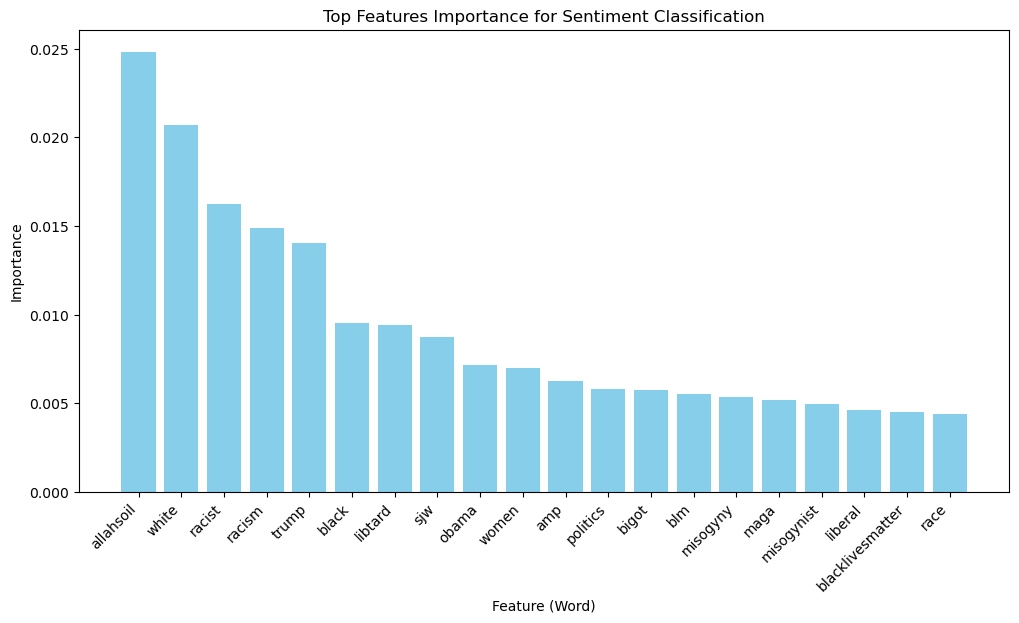

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'bow_vectorizer' is the CountVectorizer used to create the Bag of Words representation
feature_names = bow_vectorizer.get_feature_names_out()

# Create a DataFrame to store feature names and their importance scores
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_classifier.feature_importances_})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features
top_n = 20  # You can adjust this based on the number of features you want to display
top_features = feature_importance_df.head(top_n)

# Print the top features and their importance scores
print(top_features)

# Visualize the top features and their importance scores
plt.figure(figsize=(12, 6))
plt.bar(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.title('Top Features Importance for Sentiment Classification')
plt.xlabel('Feature (Word)')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.show()

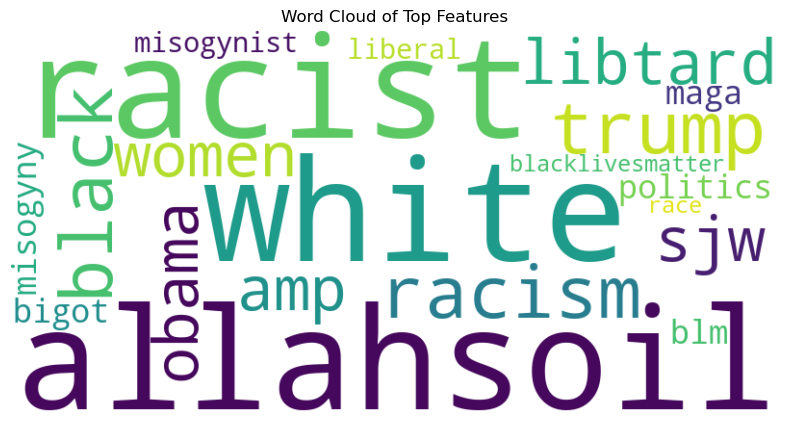

In [39]:
from wordcloud import WordCloud

# Assuming 'twitter_data' is your DataFrame
top_feature_words = top_features['Feature'].tolist()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_feature_words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Top Features')
plt.show()

##### Overall sentiment

In [40]:
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd

# Assuming 'twitter_data' is your DataFrame
top_feature_words = top_features['Feature'].tolist()

# Create a string by joining the top feature words
top_feature_text = ' '.join(top_feature_words)

# Initialize the VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Perform sentiment analysis on the concatenated text
sentiment_scores = sia.polarity_scores(top_feature_text)

# Display the sentiment scores
print("Sentiment Scores:")
print(sentiment_scores)

# Determine the overall sentiment
if sentiment_scores['compound'] >= 0.05:
    sentiment = 'Positive'
elif sentiment_scores['compound'] <= -0.05:
    sentiment = 'Negative'
else:
    sentiment = 'Neutral'

print(f"Overall Sentiment: {sentiment}")

Sentiment Scores:
{'neg': 0.31, 'neu': 0.69, 'pos': 0.0, 'compound': -0.8442}
Overall Sentiment: Negative


##### Searching text
Concordance in natural language processing refers to the contextual occurrence of a specific word within a text, showing its surrounding words. which provides insights into how a word is used and helps analyze its context within tweets_data.

In [43]:
from nltk import Text

# Assuming 'tweets_data' is your DataFrame and 'text' is the column containing the raw text
text_corpus = Text(twitter_data['tweet'].str.split().explode())

# Display the concordance of the top feature words
for feature in top_feature_words:
    print(f"Concordance for '{feature}':")
    text_corpus.concordance(feature)
    print("\n")

Concordance for 'allahsoil':
no matches


Concordance for 'white':
Displaying 25 of 154 matches:
ð½ðð½ðð½ hour ð©the white establishment can't have blk folx ru
ser 6th @user @user @user @user hey, white people: you can call people 'white' 
r the asians africa for the africans white countries for everyonâ¦ .@user on #
positive "nigger?" #lifelessons of a white kid who grew up in the 60's. #blogpo
mp used #hate, and #putin to win the white house #trump presses attack on khan 
#shop #cool #home #fun the danger of white liberalism to oveurning (applies to 
 like the spread of peanut butter on white bread! #littlewonders vmin makes me 
s! this how works in uk. if i'd been white &amp; those politician impoed thieve
ecome a pr oppounity? if #potus were white he'd still be the worst president ev
r i thought alt-right secretly meant white nationalist #altright #maga # all yo
&amp; spaâ¦ @user homegrown rightie white americans are 100 times more likely 
 the greggs? #harambe &

### Conclusion

The sentiment analysis on tweets data yielded a robust model with an impressive accuracy of 95%. Through meticulous text processing, including cleaning, tokenization, and stemming, coupled with advanced word embedding techniques such as Bag of Words and a RandomForestClassifier model, we achieved highly accurate sentiment predictions. Context analysis further provided nuanced insights into the contextual usage of key features, enabling iterative improvements in model performance.

- The analysis provides valuable insights into sentiment classification using a RandomForestClassifier.
- Continuous refinement and evaluation of the model will be crucial for maintaining its effectiveness in real-world scenarios.